In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [22]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [23]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [24]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [25]:
def draw_landmarks(image, results):
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections
    

In [26]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS,
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [28]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        # Draw landmarks
        #draw_landmarks(image, results)
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [29]:
draw_landmarks(frame, results)

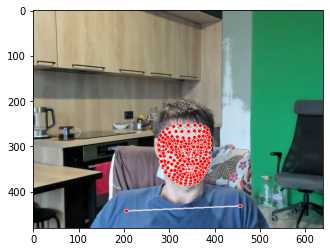

In [30]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

## 3. Extract Keypoint Values

In [31]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [32]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [33]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)


In [34]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [35]:
extract_keypoints(results).shape

(1662,)

In [19]:
468*3+33*4+21*3+21*3

1662

## 4. Setup Folders for Collection

In [36]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'frist', 'channel'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [7]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

## 5. Collect Keypoint Values for Training and Testing

In [21]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [37]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [38]:
label_map = {label:num for num, label in enumerate(actions)}

In [39]:
label_map

{'hello': 0, 'frist': 1, 'channel': 2}

### Долго вычислить

In [40]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [41]:
np.array(sequences).shape

(90, 30, 1662)

In [42]:
np.array(labels).shape

(90,)

In [43]:
X = np.array(sequences)

In [44]:
X.shape

(90, 30, 1662)

In [45]:
y = to_categorical(labels).astype(int)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [53]:
y_test.shape

(5, 3)

## 7. Build and Train LSTM Neural Network

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [55]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [56]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [57]:
res = [.7, 0.2, 0.1]

In [58]:
actions[np.argmax(res)]

'hello'

In [59]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [54]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 2s 341ms/step - loss: 1.9026 - categorical_accuracy: 0.2447
Epoch 2/2000
3/3 [==============================] - 0s 38ms/step - loss: 2.1302 - categorical_accuracy: 0.3698
Epoch 3/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.1484 - categorical_accuracy: 0.3130
Epoch 4/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.2559 - categorical_accuracy: 0.2818
Epoch 5/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0445 - categorical_accuracy: 0.5206
Epoch 6/2000
3/3 [==============================] - 0s 38ms/step - loss: 0.9259 - categorical_accuracy: 0.6106
Epoch 7/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.0733 - categorical_accuracy: 0.6320
Epoch 8/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.1854 - categorical_accuracy: 0.2975
Epoch 9/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.9431 - categorical_accuracy: 0.4502


3/3 [==============================] - 0s 34ms/step - loss: 0.3764 - categorical_accuracy: 0.8200
Epoch 75/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.3615 - categorical_accuracy: 0.8395
Epoch 76/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.2591 - categorical_accuracy: 0.9022
Epoch 77/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.3076 - categorical_accuracy: 0.8376
Epoch 78/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.2647 - categorical_accuracy: 0.8943
Epoch 79/2000
3/3 [==============================] - 0s 38ms/step - loss: 0.2410 - categorical_accuracy: 0.8983
Epoch 80/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.2309 - categorical_accuracy: 0.9022
Epoch 81/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.2065 - categorical_accuracy: 0.9002
Epoch 82/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.1487 - categorical_accuracy: 0.9335
Epoch 

3/3 [==============================] - 0s 36ms/step - loss: 51.4089 - categorical_accuracy: 0.3014
Epoch 147/2000
3/3 [==============================] - 0s 36ms/step - loss: 18.1037 - categorical_accuracy: 0.3464
Epoch 148/2000
3/3 [==============================] - 0s 37ms/step - loss: 34.2947 - categorical_accuracy: 0.4833
Epoch 149/2000
3/3 [==============================] - 0s 36ms/step - loss: 46.5094 - categorical_accuracy: 0.2153
Epoch 150/2000
3/3 [==============================] - 0s 34ms/step - loss: 18.6745 - categorical_accuracy: 0.2133
Epoch 151/2000
3/3 [==============================] - 0s 36ms/step - loss: 45.9992 - categorical_accuracy: 0.2622
Epoch 152/2000
3/3 [==============================] - 0s 36ms/step - loss: 27.1264 - categorical_accuracy: 0.3640
Epoch 153/2000
3/3 [==============================] - 0s 36ms/step - loss: 28.5142 - categorical_accuracy: 0.3111
Epoch 154/2000
3/3 [==============================] - 0s 37ms/step - loss: 21.2042 - categorical_accura

3/3 [==============================] - 0s 38ms/step - loss: 66.3758 - categorical_accuracy: 0.3287
Epoch 219/2000
3/3 [==============================] - 0s 37ms/step - loss: 38.7144 - categorical_accuracy: 0.2642
Epoch 220/2000
3/3 [==============================] - 0s 34ms/step - loss: 28.5815 - categorical_accuracy: 0.4187
Epoch 221/2000
3/3 [==============================] - 0s 35ms/step - loss: 115.7260 - categorical_accuracy: 0.1703
Epoch 222/2000
3/3 [==============================] - 0s 35ms/step - loss: 156.7976 - categorical_accuracy: 0.3053
Epoch 223/2000
3/3 [==============================] - 0s 36ms/step - loss: 122.4561 - categorical_accuracy: 0.4246
Epoch 224/2000
3/3 [==============================] - 0s 37ms/step - loss: 973.2300 - categorical_accuracy: 0.2975
Epoch 225/2000
3/3 [==============================] - 0s 37ms/step - loss: 279.5690 - categorical_accuracy: 0.3288
Epoch 226/2000
3/3 [==============================] - 0s 36ms/step - loss: 283.6678 - categorical_

3/3 [==============================] - 0s 36ms/step - loss: 2.7673 - categorical_accuracy: 0.4540
Epoch 290/2000
3/3 [==============================] - 0s 35ms/step - loss: 2.9797 - categorical_accuracy: 0.4441
Epoch 291/2000
3/3 [==============================] - 0s 36ms/step - loss: 4.6854 - categorical_accuracy: 0.4051
Epoch 292/2000
3/3 [==============================] - 0s 36ms/step - loss: 5.4172 - categorical_accuracy: 0.4227
Epoch 293/2000
3/3 [==============================] - 0s 36ms/step - loss: 2.4577 - categorical_accuracy: 0.3875
Epoch 294/2000
3/3 [==============================] - 0s 37ms/step - loss: 3.4575 - categorical_accuracy: 0.2916
Epoch 295/2000
3/3 [==============================] - 0s 37ms/step - loss: 4.0645 - categorical_accuracy: 0.3307
Epoch 296/2000
3/3 [==============================] - 0s 34ms/step - loss: 2.0954 - categorical_accuracy: 0.4208
Epoch 297/2000
3/3 [==============================] - 0s 36ms/step - loss: 3.1339 - categorical_accuracy: 0.334

3/3 [==============================] - 0s 35ms/step - loss: 1.0990 - categorical_accuracy: 0.4344
Epoch 362/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.0544 - categorical_accuracy: 0.5518
Epoch 363/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.0633 - categorical_accuracy: 0.4149
Epoch 364/2000
3/3 [==============================] - 0s 42ms/step - loss: 1.0267 - categorical_accuracy: 0.5244
Epoch 365/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.1521 - categorical_accuracy: 0.3112
Epoch 366/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0325 - categorical_accuracy: 0.4481
Epoch 367/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.1255 - categorical_accuracy: 0.2936
Epoch 368/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.4011 - categorical_accuracy: 0.2994
Epoch 369/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.1706 - categorical_accuracy: 0.436

3/3 [==============================] - 0s 38ms/step - loss: 1.2283 - categorical_accuracy: 0.4011
Epoch 434/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.3624 - categorical_accuracy: 0.4637
Epoch 435/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.3503 - categorical_accuracy: 0.4129
Epoch 436/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.6384 - categorical_accuracy: 0.3835
Epoch 437/2000
3/3 [==============================] - 0s 36ms/step - loss: 2.3438 - categorical_accuracy: 0.4657
Epoch 438/2000
3/3 [==============================] - 0s 36ms/step - loss: 2.1501 - categorical_accuracy: 0.3229
Epoch 439/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.4425 - categorical_accuracy: 0.3757
Epoch 440/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.1989 - categorical_accuracy: 0.4442
Epoch 441/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.3105 - categorical_accuracy: 0.469

3/3 [==============================] - 0s 38ms/step - loss: 1.0612 - categorical_accuracy: 0.4402
Epoch 506/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.1093 - categorical_accuracy: 0.4989
Epoch 507/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0976 - categorical_accuracy: 0.4051
Epoch 508/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0023 - categorical_accuracy: 0.4228
Epoch 509/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.0724 - categorical_accuracy: 0.4403
Epoch 510/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.9977 - categorical_accuracy: 0.5713
Epoch 511/2000
3/3 [==============================] - 0s 38ms/step - loss: 1.1394 - categorical_accuracy: 0.4716
Epoch 512/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.9969 - categorical_accuracy: 0.5538
Epoch 513/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.0866 - categorical_accuracy: 0.334

3/3 [==============================] - 0s 36ms/step - loss: 0.7718 - categorical_accuracy: 0.6281
Epoch 578/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.8878 - categorical_accuracy: 0.4853
Epoch 579/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8088 - categorical_accuracy: 0.6144
Epoch 580/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.7805 - categorical_accuracy: 0.6536
Epoch 581/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8259 - categorical_accuracy: 0.5910
Epoch 582/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.9208 - categorical_accuracy: 0.5988
Epoch 583/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8088 - categorical_accuracy: 0.6438
Epoch 584/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.7400 - categorical_accuracy: 0.6966
Epoch 585/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.7922 - categorical_accuracy: 0.594

3/3 [==============================] - 0s 35ms/step - loss: 1.0198 - categorical_accuracy: 0.5538
Epoch 650/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.9937 - categorical_accuracy: 0.5361
Epoch 651/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8986 - categorical_accuracy: 0.6164
Epoch 652/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.8846 - categorical_accuracy: 0.6125
Epoch 653/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.9162 - categorical_accuracy: 0.5617
Epoch 654/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8353 - categorical_accuracy: 0.5734
Epoch 655/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.7992 - categorical_accuracy: 0.6966
Epoch 656/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.7778 - categorical_accuracy: 0.6359
Epoch 657/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.7635 - categorical_accuracy: 0.675

3/3 [==============================] - 0s 36ms/step - loss: 0.7528 - categorical_accuracy: 0.7436
Epoch 722/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.7520 - categorical_accuracy: 0.6419
Epoch 723/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.6918 - categorical_accuracy: 0.7612
Epoch 724/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.6924 - categorical_accuracy: 0.7143
Epoch 725/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.6825 - categorical_accuracy: 0.7279
Epoch 726/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.7177 - categorical_accuracy: 0.7378
Epoch 727/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.7404 - categorical_accuracy: 0.6986
Epoch 728/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.7794 - categorical_accuracy: 0.6909
Epoch 729/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.7787 - categorical_accuracy: 0.688

3/3 [==============================] - 0s 37ms/step - loss: 0.7363 - categorical_accuracy: 0.6184
Epoch 794/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.6780 - categorical_accuracy: 0.7632
Epoch 795/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.6844 - categorical_accuracy: 0.7593
Epoch 796/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.7360 - categorical_accuracy: 0.6673
Epoch 797/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.6074 - categorical_accuracy: 0.7456
Epoch 798/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.5822 - categorical_accuracy: 0.7886
Epoch 799/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.6683 - categorical_accuracy: 0.7065
Epoch 800/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.7303 - categorical_accuracy: 0.6204
Epoch 801/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.7046 - categorical_accuracy: 0.702

3/3 [==============================] - 0s 36ms/step - loss: 0.5340 - categorical_accuracy: 0.7613
Epoch 866/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.5599 - categorical_accuracy: 0.8082
Epoch 867/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.4713 - categorical_accuracy: 0.7749
Epoch 868/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.4751 - categorical_accuracy: 0.7945
Epoch 869/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.4386 - categorical_accuracy: 0.8533
Epoch 870/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.4121 - categorical_accuracy: 0.8415
Epoch 871/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.4189 - categorical_accuracy: 0.8865
Epoch 872/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.4761 - categorical_accuracy: 0.7612
Epoch 873/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.5725 - categorical_accuracy: 0.753

3/3 [==============================] - 0s 36ms/step - loss: 0.9720 - categorical_accuracy: 0.5694
Epoch 938/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.9725 - categorical_accuracy: 0.5694
Epoch 939/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.9681 - categorical_accuracy: 0.5577
Epoch 940/2000
3/3 [==============================] - 0s 39ms/step - loss: 0.9607 - categorical_accuracy: 0.5812
Epoch 941/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.9636 - categorical_accuracy: 0.5538
Epoch 942/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.9838 - categorical_accuracy: 0.5226
Epoch 943/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.9473 - categorical_accuracy: 0.5733
Epoch 944/2000
3/3 [==============================] - 0s 38ms/step - loss: 0.9769 - categorical_accuracy: 0.5148
Epoch 945/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.9615 - categorical_accuracy: 0.547

3/3 [==============================] - 0s 39ms/step - loss: 0.8574 - categorical_accuracy: 0.5734
Epoch 1010/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.8872 - categorical_accuracy: 0.5754
Epoch 1011/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8419 - categorical_accuracy: 0.6105
Epoch 1012/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.8690 - categorical_accuracy: 0.5792
Epoch 1013/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8845 - categorical_accuracy: 0.5930
Epoch 1014/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.8954 - categorical_accuracy: 0.6086
Epoch 1015/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.8835 - categorical_accuracy: 0.5930
Epoch 1016/2000
3/3 [==============================] - 0s 39ms/step - loss: 0.8688 - categorical_accuracy: 0.5949
Epoch 1017/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8603 - categorical_accurac

3/3 [==============================] - 0s 36ms/step - loss: 0.8632 - categorical_accuracy: 0.6047
Epoch 1082/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8700 - categorical_accuracy: 0.5793
Epoch 1083/2000
3/3 [==============================] - 0s 38ms/step - loss: 0.8883 - categorical_accuracy: 0.5890
Epoch 1084/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.8205 - categorical_accuracy: 0.6281
Epoch 1085/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.8385 - categorical_accuracy: 0.6281
Epoch 1086/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.8463 - categorical_accuracy: 0.5969
Epoch 1087/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.8788 - categorical_accuracy: 0.5813
Epoch 1088/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.8417 - categorical_accuracy: 0.6105
Epoch 1089/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8705 - categorical_accurac

3/3 [==============================] - 0s 36ms/step - loss: 0.8986 - categorical_accuracy: 0.5676
Epoch 1154/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8661 - categorical_accuracy: 0.5910
Epoch 1155/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8488 - categorical_accuracy: 0.5949
Epoch 1156/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8660 - categorical_accuracy: 0.5715
Epoch 1157/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.8751 - categorical_accuracy: 0.6360
Epoch 1158/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8812 - categorical_accuracy: 0.5715
Epoch 1159/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.8312 - categorical_accuracy: 0.6574
Epoch 1160/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.9018 - categorical_accuracy: 0.5754
Epoch 1161/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8584 - categorical_accurac

3/3 [==============================] - 0s 37ms/step - loss: 0.8204 - categorical_accuracy: 0.6086
Epoch 1226/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8622 - categorical_accuracy: 0.5988
Epoch 1227/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.8448 - categorical_accuracy: 0.5852
Epoch 1228/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8216 - categorical_accuracy: 0.6340
Epoch 1229/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8871 - categorical_accuracy: 0.5969
Epoch 1230/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8994 - categorical_accuracy: 0.5695
Epoch 1231/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8787 - categorical_accuracy: 0.5910
Epoch 1232/2000
3/3 [==============================] - 0s 38ms/step - loss: 0.8039 - categorical_accuracy: 0.6203
Epoch 1233/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.8815 - categorical_accurac

3/3 [==============================] - 0s 34ms/step - loss: 0.8217 - categorical_accuracy: 0.6144
Epoch 1298/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.8486 - categorical_accuracy: 0.5734
Epoch 1299/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.8502 - categorical_accuracy: 0.5813
Epoch 1300/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8382 - categorical_accuracy: 0.5969
Epoch 1301/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8339 - categorical_accuracy: 0.6086
Epoch 1302/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.8734 - categorical_accuracy: 0.5871
Epoch 1303/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.8383 - categorical_accuracy: 0.6301
Epoch 1304/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8456 - categorical_accuracy: 0.5930
Epoch 1305/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8249 - categorical_accurac

3/3 [==============================] - 0s 34ms/step - loss: 0.8493 - categorical_accuracy: 0.6106
Epoch 1370/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8536 - categorical_accuracy: 0.6204
Epoch 1371/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8915 - categorical_accuracy: 0.5891
Epoch 1372/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.8290 - categorical_accuracy: 0.5910
Epoch 1373/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8026 - categorical_accuracy: 0.6477
Epoch 1374/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.8362 - categorical_accuracy: 0.6204
Epoch 1375/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8470 - categorical_accuracy: 0.6086
Epoch 1376/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8462 - categorical_accuracy: 0.6086
Epoch 1377/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.8727 - categorical_accurac

3/3 [==============================] - 0s 36ms/step - loss: 309.7985 - categorical_accuracy: 0.3131
Epoch 1441/2000
3/3 [==============================] - 0s 38ms/step - loss: 254.4438 - categorical_accuracy: 0.2994
Epoch 1442/2000
3/3 [==============================] - 0s 34ms/step - loss: 92.4258 - categorical_accuracy: 0.5028
Epoch 1443/2000
3/3 [==============================] - 0s 36ms/step - loss: 138.8356 - categorical_accuracy: 0.3503
Epoch 1444/2000
3/3 [==============================] - 0s 35ms/step - loss: 88.7133 - categorical_accuracy: 0.3386
Epoch 1445/2000
3/3 [==============================] - 0s 35ms/step - loss: 41.7628 - categorical_accuracy: 0.2721
Epoch 1446/2000
3/3 [==============================] - 0s 38ms/step - loss: 54.4179 - categorical_accuracy: 0.2662
Epoch 1447/2000
3/3 [==============================] - 0s 37ms/step - loss: 28.2191 - categorical_accuracy: 0.3757
Epoch 1448/2000
3/3 [==============================] - 0s 39ms/step - loss: 11.0643 - categor

3/3 [==============================] - 0s 34ms/step - loss: 1.0958 - categorical_accuracy: 0.3913
Epoch 1512/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.1019 - categorical_accuracy: 0.3405
Epoch 1513/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0957 - categorical_accuracy: 0.3796
Epoch 1514/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0941 - categorical_accuracy: 0.3835
Epoch 1515/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.1005 - categorical_accuracy: 0.3405
Epoch 1516/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0977 - categorical_accuracy: 0.3757
Epoch 1517/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.1009 - categorical_accuracy: 0.3523
Epoch 1518/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.0968 - categorical_accuracy: 0.3679
Epoch 1519/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.1066 - categorical_accurac

3/3 [==============================] - 0s 38ms/step - loss: 1.0959 - categorical_accuracy: 0.3796
Epoch 1584/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.1016 - categorical_accuracy: 0.3327
Epoch 1585/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.0995 - categorical_accuracy: 0.3444
Epoch 1586/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.1005 - categorical_accuracy: 0.3366
Epoch 1587/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.0968 - categorical_accuracy: 0.3718
Epoch 1588/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.1002 - categorical_accuracy: 0.3366
Epoch 1589/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.1011 - categorical_accuracy: 0.3249
Epoch 1590/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.0946 - categorical_accuracy: 0.3757
Epoch 1591/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.0977 - categorical_accurac

3/3 [==============================] - 0s 36ms/step - loss: 1.0950 - categorical_accuracy: 0.3796
Epoch 1656/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0965 - categorical_accuracy: 0.3640
Epoch 1657/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.0952 - categorical_accuracy: 0.3796
Epoch 1658/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0955 - categorical_accuracy: 0.3757
Epoch 1659/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.0958 - categorical_accuracy: 0.3718
Epoch 1660/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0990 - categorical_accuracy: 0.3405
Epoch 1661/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.0987 - categorical_accuracy: 0.3444
Epoch 1662/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.0954 - categorical_accuracy: 0.3757
Epoch 1663/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0977 - categorical_accurac

3/3 [==============================] - 0s 36ms/step - loss: 1.0989 - categorical_accuracy: 0.3366
Epoch 1728/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.0999 - categorical_accuracy: 0.3288
Epoch 1729/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.0965 - categorical_accuracy: 0.3640
Epoch 1730/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0982 - categorical_accuracy: 0.3483
Epoch 1731/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0987 - categorical_accuracy: 0.3405
Epoch 1732/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.0977 - categorical_accuracy: 0.3562
Epoch 1733/2000
3/3 [==============================] - 0s 34ms/step - loss: 1.0985 - categorical_accuracy: 0.3523
Epoch 1734/2000
3/3 [==============================] - 0s 34ms/step - loss: 1.1006 - categorical_accuracy: 0.3171
Epoch 1735/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0985 - categorical_accurac

3/3 [==============================] - 0s 36ms/step - loss: 1.0979 - categorical_accuracy: 0.3405
Epoch 1800/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0983 - categorical_accuracy: 0.3483
Epoch 1801/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.0965 - categorical_accuracy: 0.3601
Epoch 1802/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.0938 - categorical_accuracy: 0.3835
Epoch 1803/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.0973 - categorical_accuracy: 0.3523
Epoch 1804/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.0991 - categorical_accuracy: 0.3483
Epoch 1805/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0983 - categorical_accuracy: 0.3523
Epoch 1806/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0944 - categorical_accuracy: 0.3874
Epoch 1807/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.0995 - categorical_accurac

3/3 [==============================] - 0s 39ms/step - loss: 1.0981 - categorical_accuracy: 0.3523
Epoch 1872/2000
3/3 [==============================] - 0s 34ms/step - loss: 1.0982 - categorical_accuracy: 0.3483
Epoch 1873/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.0967 - categorical_accuracy: 0.3562
Epoch 1874/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.0940 - categorical_accuracy: 0.3835
Epoch 1875/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.0974 - categorical_accuracy: 0.3601
Epoch 1876/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0988 - categorical_accuracy: 0.3523
Epoch 1877/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.0963 - categorical_accuracy: 0.3679
Epoch 1878/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.0964 - categorical_accuracy: 0.3601
Epoch 1879/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.0943 - categorical_accurac

3/3 [==============================] - 0s 34ms/step - loss: 1.0955 - categorical_accuracy: 0.3679
Epoch 1944/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.0992 - categorical_accuracy: 0.3327
Epoch 1945/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0972 - categorical_accuracy: 0.3523
Epoch 1946/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.1005 - categorical_accuracy: 0.3249
Epoch 1947/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0986 - categorical_accuracy: 0.3327
Epoch 1948/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0980 - categorical_accuracy: 0.3444
Epoch 1949/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.0970 - categorical_accuracy: 0.3562
Epoch 1950/2000
3/3 [==============================] - 0s 36ms/step - loss: 1.0995 - categorical_accuracy: 0.3405
Epoch 1951/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.0955 - categorical_accurac

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 64)            442112    
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
________________________________________________

## 8. Make Predictions

In [60]:
res = model.predict(X_test)

In [63]:
actions[np.argmax(res[1])]

'hello'

In [64]:
actions[np.argmax(y_test[1])]

'hello'

## 9. Save Weights

In [65]:
model.save('action_1tv.h5')

In [62]:
del model

In [66]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))


model.load_weights('action_1tv.h5')

In [119]:
model.load_weights('action_1tv.h5')
#model.load_weights('action.h5')

## 10. Evaluation using Confusion Matrix and Accuracy

In [120]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [121]:
yhat = model.predict(X_train)

In [122]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [123]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[26, 31],
        [13, 15]],

       [[34, 24],
        [12, 15]],

       [[55,  0],
        [30,  0]]], dtype=int64)

In [124]:
accuracy_score(ytrue, yhat)

0.35294117647058826

## 11. Test in Real Time

In [126]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

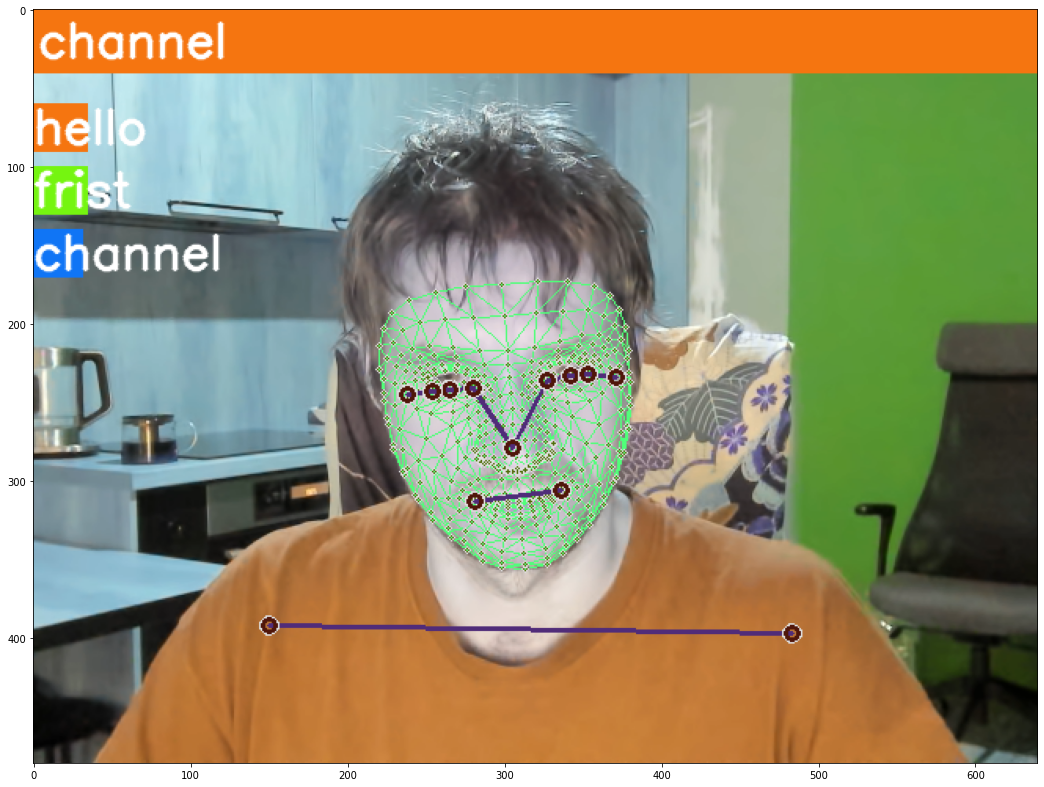

In [127]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [129]:
sequence = []
sentence = []
threshold = 0.8
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        #draw_landmarks(image, results)
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.insert(0,keypoints)
        #sequence.append(keypoints)
        sequence = sequence[:30]
        #sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])        
        
        #3. Viz logic
        if res[np.argmax(res)] > threshold: 
            if len(sentence) > 0: 
                if actions[np.argmax(res)] != sentence[-1]:
                    sentence.append(actions[np.argmax(res)])
            else:
                sentence.append(actions[np.argmax(res)])
                
        if len(sentence) > 5: 
            sentence = sentence[-5:]       
        
        # Viz probabilities
        image = prob_viz(res, actions, image, colors)
        
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)        

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [97]:
np.expand_dims(X_test[0],axis=0)

array([[[ 0.62245953,  0.37038982, -0.9761529 , ...,  0.505225  ,
          0.57214153, -0.02689198],
        [ 0.57644916,  0.36945379, -0.87250268, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.56194961,  0.36899036, -0.88155806, ...,  0.4235948 ,
          0.5714466 , -0.03144754],
        ...,
        [ 0.58863461,  0.36854106, -1.20074117, ...,  0.47710121,
          0.58552611, -0.03708823],
        [ 0.59093857,  0.36856499, -1.19064867, ...,  0.46716875,
          0.58387071, -0.0363292 ],
        [ 0.590891  ,  0.36635515, -0.98833781, ...,  0.46415049,
          0.57998842, -0.03620665]]])

In [96]:
X_test[0].shape

(30, 1662)

In [79]:
model.predict(np.expand_dims(X_test[0], axis=0))

array([[0.34126526, 0.3441711 , 0.31456357]], dtype=float32)

### Action Detection Tutorial

In [131]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'

### Action Detection Refined

In [130]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'

<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'>
frist
<class 'mediapipe.python.solution_base.SolutionOutputs'